# ANALISIS SENTIMEN TERKAIT KEBIJAKAN TEPERA PADA PLATFORM TWITTER (X) MENGGUNAKAN ALGORITMA NAIVE BAYES DAN SUPPORT VECTOR MACHINE

## 1. IMPORT LIBRARY

In [29]:
import pandas as pd 
import numpy as np 

# import library nltk untuk pengolahan bahasa alami
from nltk.corpus import stopwords
import nltk 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from deep_translator import GoogleTranslator

# import library re dan unicode untuk regular expressions dan manipulasi unicode
import re, unicodedata

# import library sklearn untuk preprocessing teks
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# import library sklearn untuk pemodelan
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# import library sklearn untuk evaluasi model
from sklearn.metrics import roc_auc_score

# import library visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# import library textblob untuk analisis teks
from textblob import Word
from textblob import TextBlob

# mengabaikan warning
import warnings
warnings.filterwarnings('ignore')


## 2. MENGGABUNGKAN HASIL CRAWLING DATA SENTIMEN DARI TWITER

In [5]:
import os

# mendefinisikan path directory yang berisi file CSV
directory = 'tweets-data'

# menggabungkan semua file CSV menjadi satu DataFrame
dataframes = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dataframes.append(df)

# menggabungkan semua DataFrame menjadi satu
data = pd.concat(dataframes, ignore_index=True)

# menyimpan data gabungan ke file CSV baru
data.to_csv('hasil-crawling.csv', index=False)


## 3. LOAD DATASET

In [6]:
# membaca dataset dari file csv yang telah digabungkan
data = pd.read_csv("hasil-crawling.csv")

In [7]:
# melihat 5 data teratas dari dataset
data.head(4)

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1799346500826501465,Sat Jun 08 07:43:30 +0000 2024,0,tabungan Perumahan Rakyat (Tapera) untuk pembi...,1799346500826501465,https://pbs.twimg.com/media/GPiP-3YacAA1dX-.jpg,NaN,in,NaN,0,0,0,https://x.com/DJ_ATALIACHAN/status/17993465008...,1510579150779666436,DJ_ATALIACHAN
1,1799346321826165013,Sat Jun 08 07:42:48 +0000 2024,0,program Tapera adalah satu langkah yang baik d...,1799346321826165013,https://pbs.twimg.com/media/GPiP4jMbsAEbEv9.jpg,NaN,in,NaN,0,0,0,https://x.com/DJ_ATALIACHAN/status/17993463218...,1510579150779666436,DJ_ATALIACHAN
2,1799346735225127199,Sat Jun 08 07:44:26 +0000 2024,0,Tapera untuk pekerja #Tapera #TabunganPerumaha...,1799346735225127199,https://pbs.twimg.com/media/GPiQUNHboAAQZoC.jpg,NaN,in,NaN,0,0,0,https://x.com/DJ_ATALIACHAN/status/17993467352...,1510579150779666436,DJ_ATALIACHAN
3,1799346214334603712,Sat Jun 08 07:42:22 +0000 2024,0,urgensi program tapera untuk kesejahteraan pek...,1799346214334603712,https://pbs.twimg.com/media/GPiP01pbkAASwpO.jpg,NaN,in,NaN,0,0,0,https://x.com/DJ_ATALIACHAN/status/17993462143...,1510579150779666436,DJ_ATALIACHAN


In [8]:
# melihat informasi data secara umum
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2366 entries, 0 to 2365
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   conversation_id_str      2366 non-null   int64 
 1   created_at               2366 non-null   object
 2   favorite_count           2366 non-null   int64 
 3   full_text                2366 non-null   object
 4   id_str                   2366 non-null   int64 
 5   image_url                1158 non-null   object
 6   in_reply_to_screen_name  221 non-null    object
 7   lang                     2366 non-null   object
 8   location                 1529 non-null   object
 9   quote_count              2366 non-null   int64 
 10  reply_count              2366 non-null   int64 
 11  retweet_count            2366 non-null   int64 
 12  tweet_url                2366 non-null   object
 13  user_id_str              2366 non-null   int64 
 14  username                 2366 non-null  

In [10]:
# melihat kolom dari dataset
data.columns

Index(['conversation_id_str', 'created_at', 'favorite_count', 'full_text',
       'id_str', 'image_url', 'in_reply_to_screen_name', 'lang', 'location',
       'quote_count', 'reply_count', 'retweet_count', 'tweet_url',
       'user_id_str', 'username'],
      dtype='object')

In [11]:
# melihat dimensi dari dataset
data.shape
# terdapat 2366 data dengan 15 features ]

(2366, 15)

In [12]:
# melihat statistika desktiptif dari tipe data string
data.describe(include='object')

,created_at,full_text,image_url,in_reply_to_screen_name,lang,location,tweet_url,username
count,2366,2366,1158,221,2366,1529,2366,2366
unique,2146,2149,1015,138,18,555,2154,1340
top,Sun Jun 02 11:31:09 +0000 2024,#TolakTapera,https://pbs.twimg.com/media/GPEKqq1aAAAEACu.jpg,wikidpr,in,Indonesia,https://x.com/Metro_TV/status/1797229461701853576,Metro_TV
freq,4,5,4,12,2200,240,4,63


In [13]:
# melihat statistika desktiptif dari data numerikal
data.describe()

,conversation_id_str,favorite_count,id_str,quote_count,reply_count,retweet_count,user_id_str
count,2.366000e+03,2366.000000,2.366000e+03,2366.000000,2366.000000,2366.000000,2.366000e+03
mean,1.736349e+18,453.196534,1.736357e+18,31.257396,30.989856,134.636940,5.988125e+17
std,2.626369e+17,2787.702157,2.626388e+17,276.456795,194.299803,811.543148,6.958610e+17
min,2.171015e+17,0.000000,2.171015e+17,0.000000,0.000000,0.000000,6.689892e+06
25%,1.797822e+18,0.000000,1.797823e+18,0.000000,0.000000,0.000000,1.357955e+08
50%,1.798185e+18,3.000000,1.798199e+18,0.000000,0.000000,1.000000,2.892770e+09
75%,1.798685e+18,16.000000,1.798686e+18,1.000000,2.000000,5.000000,1.322361e+18
max,1.801432e+18,54778.000000,1.801432e+18,8685.000000,3991.000000,13449.000000,1.793151e+18


In [15]:
# melihat jumlah data yang missing
data.isnull().sum()


conversation_id_str           0
created_at                    0
favorite_count                0
full_text                     0
id_str                        0
image_url                  1208
in_reply_to_screen_name    2145
lang                          0
location                    837
quote_count                   0
reply_count                   0
retweet_count                 0
tweet_url                     0
user_id_str                   0
username                      0
dtype: int64

In [16]:
percentage = (data.isnull().sum() / len(data)) * 100
percentage

conversation_id_str         0.000000
created_at                  0.000000
favorite_count              0.000000
full_text                   0.000000
id_str                      0.000000
image_url                  51.056636
in_reply_to_screen_name    90.659341
lang                        0.000000
location                   35.376162
quote_count                 0.000000
reply_count                 0.000000
retweet_count               0.000000
tweet_url                   0.000000
user_id_str                 0.000000
username                    0.000000
dtype: float64

In [19]:
# drop data yang null
data.dropna(inplace=True)
# crosscheck apakah data null sudah terhapus
data.isnull().sum()

conversation_id_str        0
created_at                 0
favorite_count             0
full_text                  0
id_str                     0
image_url                  0
in_reply_to_screen_name    0
lang                       0
location                   0
quote_count                0
reply_count                0
retweet_count              0
tweet_url                  0
user_id_str                0
username                   0
dtype: int64

## 4. DATA PREPROCESSING

### 4.1 Ubah Text Ke Bahasa Inggris

In [30]:
# inisiasi translator
translator = GoogleTranslator(source='auto', target='en')

In [ ]:
# menerjemahkan tweet ke bahasa Inggris
data['tweet_english'] = data['full_text'].apply(lambda x: translator.translate(x))

In [44]:
kolom = ['full_text', 'tweet_english']
data[kolom].head(4)

,full_text,tweet_english
255,@democrazymedia Yang Mulia Pinokio: Kalian itu...,@democrazymedia Your Excellency Pinocchio: How...
359,@democrazymedia Yang Mulia Pinokio: Kalian itu...,@democrazymedia His Highness Pinocchio: You gu...
521,Investasi Bodong Tapera #TolakTapera https://t...,Bodong Tapera Investment #RejectTapera https:/...
695,Tapera itu sebuah bidang inovasi pembiayaan ta...,Tapera is a field of tapera financing innovati...


### 4.2 Menghapus Karakter Khusus dan Angka dari Tweet

In [56]:
# menghapus karakter khusus dan angka dari tweet
data['tweet_clean'] = data['tweet_english'].apply(lambda x: re.sub('[^a-zA-Z\s]', '', x))
kolom = ['tweet_clean', 'tweet_english','full_text']
data[kolom].head(4)

,tweet_clean,tweet_english,full_text
255,democrazymedia Your Excellency Pinocchio How c...,@democrazymedia Your Excellency Pinocchio: How...,@democrazymedia Yang Mulia Pinokio: Kalian itu...
359,democrazymedia His Highness Pinocchio You guys...,@democrazymedia His Highness Pinocchio: You gu...,@democrazymedia Yang Mulia Pinokio: Kalian itu...
521,Bodong Tapera Investment RejectTapera httpstco...,Bodong Tapera Investment #RejectTapera https:/...,Investasi Bodong Tapera #TolakTapera https://t...
695,Tapera is a field of tapera financing innovati...,Tapera is a field of tapera financing innovati...,Tapera itu sebuah bidang inovasi pembiayaan ta...


### 4.3 Mengubah Data Tweet menjadi Huruf Kecil

In [57]:
# mengubah teks menjadi huruf kecil
data['tweet_clean'] = data['tweet_clean'].apply(lambda x: x.lower())
data[kolom].head(4)

,tweet_clean,tweet_english,full_text
255,democrazymedia your excellency pinocchio how c...,@democrazymedia Your Excellency Pinocchio: How...,@democrazymedia Yang Mulia Pinokio: Kalian itu...
359,democrazymedia his highness pinocchio you guys...,@democrazymedia His Highness Pinocchio: You gu...,@democrazymedia Yang Mulia Pinokio: Kalian itu...
521,bodong tapera investment rejecttapera httpstco...,Bodong Tapera Investment #RejectTapera https:/...,Investasi Bodong Tapera #TolakTapera https://t...
695,tapera is a field of tapera financing innovati...,Tapera is a field of tapera financing innovati...,Tapera itu sebuah bidang inovasi pembiayaan ta...


### 4.4 Menghapus Stopwords pada Data Tweet

In [58]:
# menghapus stopwords
stop_words = set(stopwords.words('english'))
data['tweet_clean'] = data['tweet_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
data[kolom].head(4)

,tweet_clean,tweet_english,full_text
255,democrazymedia excellency pinocchio come guys ...,@democrazymedia Your Excellency Pinocchio: How...,@democrazymedia Yang Mulia Pinokio: Kalian itu...
359,democrazymedia highness pinocchio guys believe...,@democrazymedia His Highness Pinocchio: You gu...,@democrazymedia Yang Mulia Pinokio: Kalian itu...
521,bodong tapera investment rejecttapera httpstco...,Bodong Tapera Investment #RejectTapera https:/...,Investasi Bodong Tapera #TolakTapera https://t...
695,tapera field tapera financing innovation mean ...,Tapera is a field of tapera financing innovati...,Tapera itu sebuah bidang inovasi pembiayaan ta...


### 4.5 Mengubah Sebuah Kata menjadi Kata Dasarnya (Lemmatization)

In [59]:
data['tweet_clean'] = data['tweet_clean'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data[kolom].head(4)

,tweet_clean,tweet_english,full_text
255,democrazymedia excellency pinocchio come guy b...,@democrazymedia Your Excellency Pinocchio: How...,@democrazymedia Yang Mulia Pinokio: Kalian itu...
359,democrazymedia highness pinocchio guy believe ...,@democrazymedia His Highness Pinocchio: You gu...,@democrazymedia Yang Mulia Pinokio: Kalian itu...
521,bodong tapera investment rejecttapera httpstco...,Bodong Tapera Investment #RejectTapera https:/...,Investasi Bodong Tapera #TolakTapera https://t...
695,tapera field tapera financing innovation mean ...,Tapera is a field of tapera financing innovati...,Tapera itu sebuah bidang inovasi pembiayaan ta...


### 4.6 Stemming pada Data Tweet

In [60]:
# Stemming kata-kata
stemmer = PorterStemmer()
data['tweet_clean'] = data['tweet_clean'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
data[kolom].head(4)

,tweet_clean,tweet_english,full_text
255,democrazymedia excel pinocchio come guy believ...,@democrazymedia Your Excellency Pinocchio: How...,@democrazymedia Yang Mulia Pinokio: Kalian itu...
359,democrazymedia high pinocchio guy believ say d...,@democrazymedia His Highness Pinocchio: You gu...,@democrazymedia Yang Mulia Pinokio: Kalian itu...
521,bodong tapera invest rejecttapera httpstcoegwx...,Bodong Tapera Investment #RejectTapera https:/...,Investasi Bodong Tapera #TolakTapera https://t...
695,tapera field tapera financ innov mean sir http...,Tapera is a field of tapera financing innovati...,Tapera itu sebuah bidang inovasi pembiayaan ta...


## 5. EXTRACT FEATURE

### 5.1 Menghitung Jumlah Kata dalam Satu Tweet

In [62]:
data['jumlah_kata'] = data['tweet_clean'].apply(lambda x: len(str(x).split(' ')))
kolom = ['tweet_clean', 'jumlah_kata']
data[kolom].head(4)

,tweet_clean,jumlah_kata
255,democrazymedia excel pinocchio come guy believ...,13
359,democrazymedia high pinocchio guy believ say d...,11
521,bodong tapera invest rejecttapera httpstcoegwx...,5
695,tapera field tapera financ innov mean sir http...,8


### 5.2 Menghitung Jumlah Karakter dalam Satu Tweet

In [63]:
data['jumlah_char'] = data['tweet_clean'].str.len()
kolom = ['tweet_clean', 'jumlah_kata', 'jumlah_char']
data[kolom].head(4)

,tweet_clean,jumlah_kata,jumlah_char
255,democrazymedia excel pinocchio come guy believ...,13,93
359,democrazymedia high pinocchio guy believ say d...,11,84
521,bodong tapera invest rejecttapera httpstcoegwx...,5,52
695,tapera field tapera financ innov mean sir http...,8,59


### 5.3 Menghitung Rata-rata Panjang Kata dalam Satu Tweet

In [64]:
data['rata_rata_kata'] = data['jumlah_char'] / data['jumlah_kata']
data['rata_rata_kata'] = [round(x, 2) for x in data['rata_rata_kata'].values]
kolom = ['tweet_clean', 'jumlah_kata', 'jumlah_char', 'rata_rata_kata']
data[kolom].head(4)

,tweet_clean,jumlah_kata,jumlah_char,rata_rata_kata
255,democrazymedia excel pinocchio come guy believ...,13,93,7.15
359,democrazymedia high pinocchio guy believ say d...,11,84,7.64
521,bodong tapera invest rejecttapera httpstcoegwx...,5,52,10.40
695,tapera field tapera financ innov mean sir http...,8,59,7.38


### 5.4 Labeling pada Data Tweet

In [66]:
# pelabelan menggunakan VADER Sentiment Analysis yang dirancang khusus untuk media sosial
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Inisiasi VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [67]:
# Membuat fungsi untuk memberikan label sentimen
def vader_sentiment(text):
    scores = sid.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [69]:
# Mengaplikasikan fungsi ke setiap tweet
data['sentiment'] = data['tweet_clean'].apply(vader_sentiment)
kolom = ['sentiment','tweet_clean', 'jumlah_kata', 'jumlah_char', 'rata_rata_kata']
data[kolom].head(10)

,sentiment,tweet_clean,jumlah_kata,jumlah_char,rata_rata_kata
255,positive,democrazymedia excel pinocchio come guy believ...,13,93,7.15
359,neutral,democrazymedia high pinocchio guy believ say d...,11,84,7.64
521,neutral,bodong tapera invest rejecttapera httpstcoegwx...,5,52,10.40
695,neutral,tapera field tapera financ innov mean sir http...,8,59,7.38
722,positive,zahraamalia offici document also assess accord...,30,192,6.40
723,neutral,mardiasih tapera version httpstcooprqmrx,4,40,10.00
885,neutral,b jo da tapera al anoth desalin system inaugur...,22,172,7.82
1016,negative,even tapera rule deduct detail paid person emp...,20,137,6.85
1086,neutral,pleas check tapera websit httpstcohieylnkyg ht...,6,58,9.67
1089,positive,even funnier behavior parti pdip pk use enthus...,21,150,7.14


## 6. VISUALISASI DATA

### 6.1 Menghitung Correlation Score

In [74]:
# karena nilai sentimen berbentuk string, lakukan perubahan sentimen menjadi nilai numerik
sentiment_encoding = {'positive': 1, 'neutral': 0, 'negative': -1}
data['sentiment_num'] = data['sentiment'].map(sentiment_encoding)

In [75]:
# Menghitung matriks korelasi hanya untuk kolom yang relevan
kolom = ['sentiment_num', 'jumlah_kata', 'jumlah_char', 'rata_rata_kata']
correlation_matrix = data[kolom].corr()

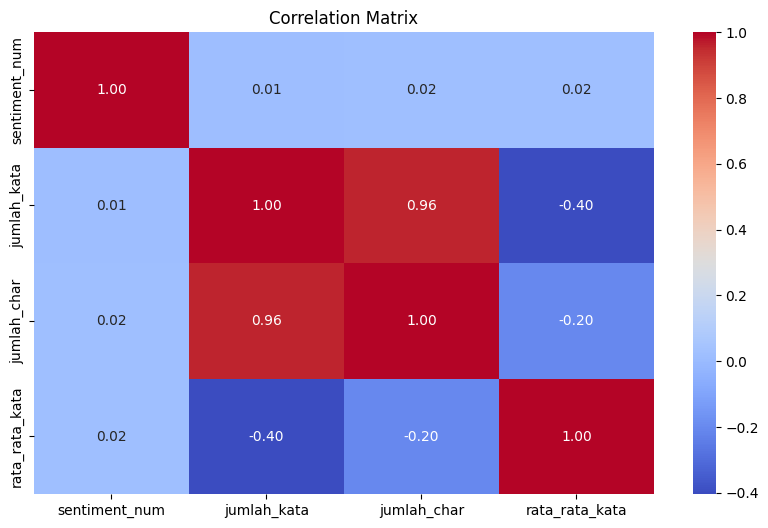

In [76]:
# Visualisasi matriks korelasi
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### 6.2 Univariate Analysis

Text(0, 0.5, 'Frekuensi')

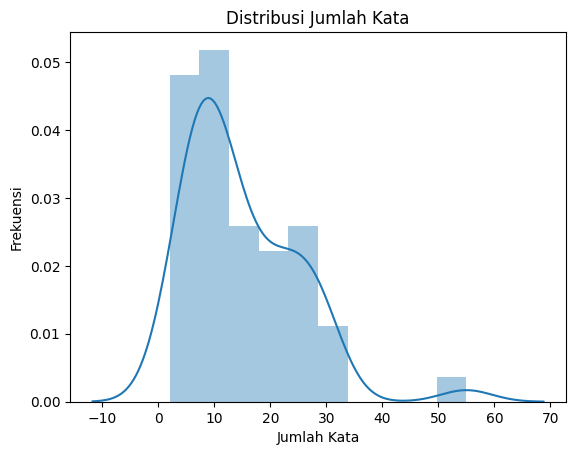

In [87]:
# univariate analisis jumlah kata

# histogram distribusi jumlah kata
sns.distplot(data['jumlah_kata'], kde=True, bins=10)  
plt.title('Distribusi Jumlah Kata')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')


Text(0, 0.5, 'Jumlah Kata')

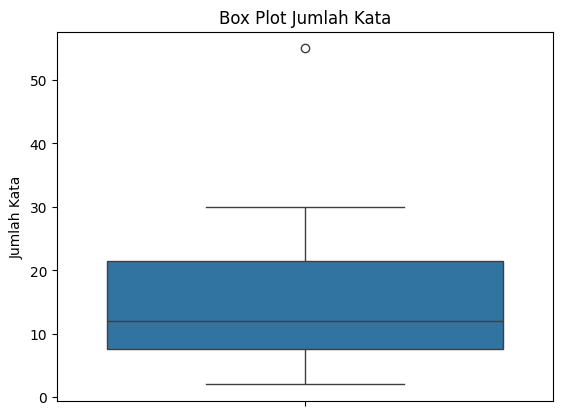

In [90]:
# box plot distribusi jumlah kata
sns.boxplot(data['jumlah_kata'])
plt.title('Box Plot Jumlah Kata')
plt.ylabel('Jumlah Kata')

Text(0, 0.5, 'Frekuensi')

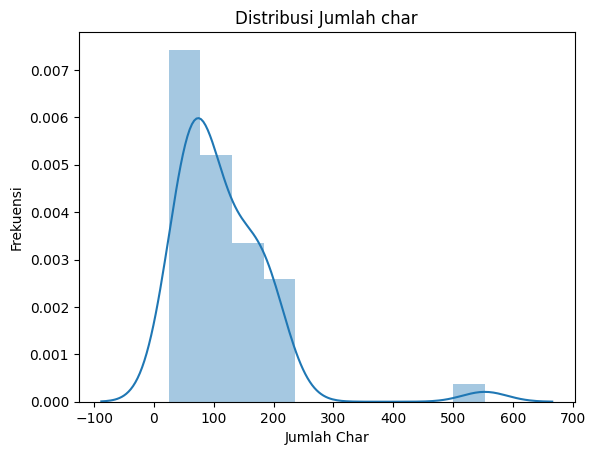

In [91]:
# univariate analisis jumlah char

# histogram distribusi jumlah char
sns.distplot(data['jumlah_char'], kde=True, bins=10)  
plt.title('Distribusi Jumlah char')
plt.xlabel('Jumlah Char')
plt.ylabel('Frekuensi')

Text(0, 0.5, 'Jumlah Char')

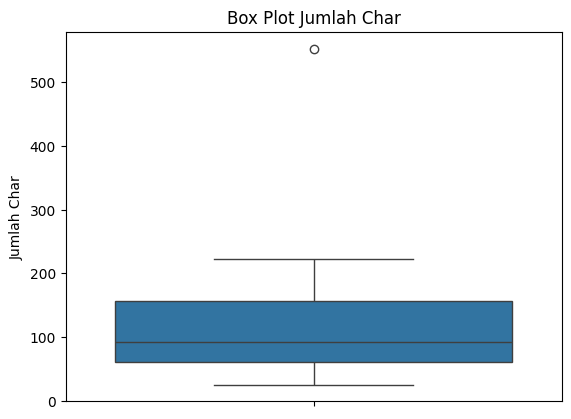

In [92]:
# box plot distribusi jumlah char
sns.boxplot(data['jumlah_char'])
plt.title('Box Plot Jumlah Char')
plt.ylabel('Jumlah Char')

Text(0, 0.5, 'Frekuensi')

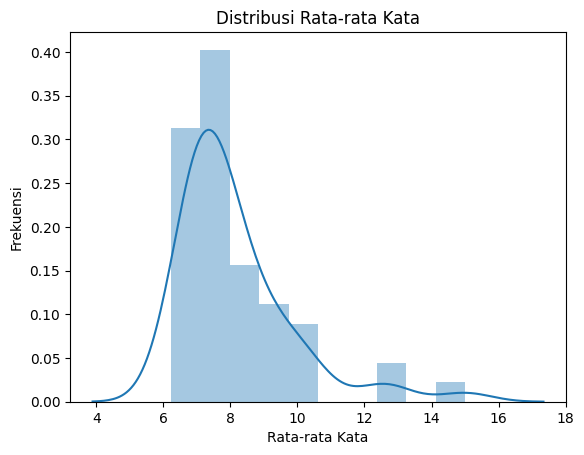

In [94]:
# univariate analisis rata-rata kata

# histogram distribusi rata-rata kata
sns.distplot(data['rata_rata_kata'], kde=True, bins=10)  
plt.title('Distribusi Rata-rata Kata')
plt.xlabel('Rata-rata Kata')
plt.ylabel('Frekuensi')

Text(0, 0.5, 'Rata-rata Kata')

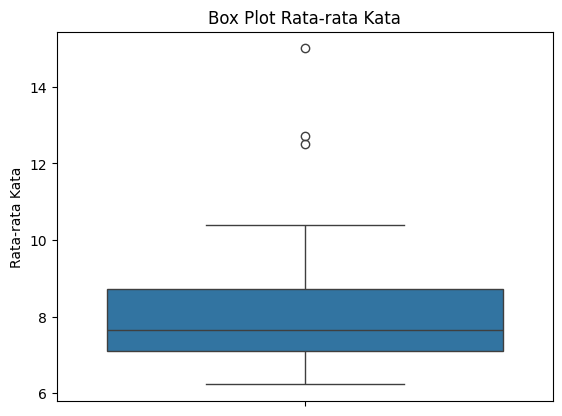

In [96]:
# box plot distribusi rata-rata kata
sns.boxplot(data['rata_rata_kata'])
plt.title('Box Plot Rata-rata Kata')
plt.ylabel('Rata-rata Kata')

### 6.3 Perbandingan Sentimen

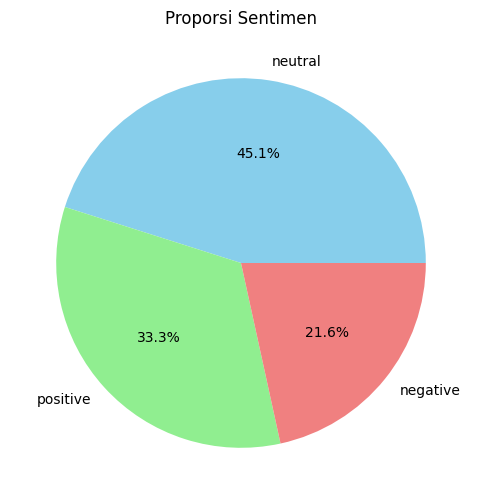

In [101]:
# Menghitung jumlah masing-masing sentimen
sentimen_counts = data['sentiment'].value_counts()

# Plot diagram lingkaran
plt.figure(figsize=(6, 6))
plt.pie(sentimen_counts, labels=sentimen_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen','lightcoral'])
plt.title('Proporsi Sentimen')
plt.show()

### 6.4 Wordcloud

In [102]:
# Memfilter data untuk masing-masing sentimen
positive_tweets = data[data['sentiment'] == 'positive']['tweet_clean']
negative_tweets = data[data['sentiment'] == 'negative']['tweet_clean']
neutral_tweets = data[data['sentiment'] == 'neutral']['tweet_clean']

Text(0.5, 1.0, 'Word Cloud untuk Sentimen Positif')

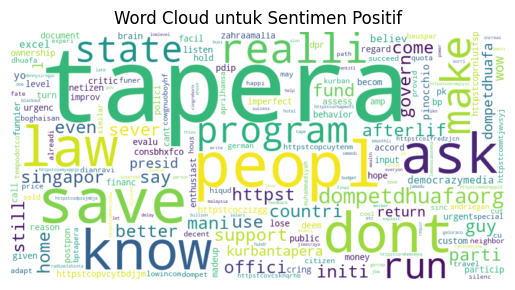

In [103]:
# Membuat WordCloud untuk sentimen positif
all_positive_text = ' '.join(positive_tweets)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(all_positive_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Positif')

Text(0.5, 1.0, 'Word Cloud untuk Sentimen Negatif')

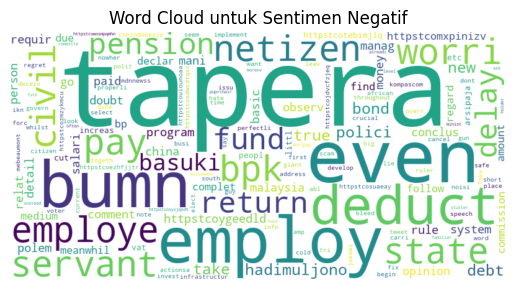

In [104]:
# Membuat WordCloud untuk sentimen negatif
all_negative_text = ' '.join(negative_tweets)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(all_negative_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Negatif')

Text(0.5, 1.0, 'Word Cloud untuk Sentimen Netral')

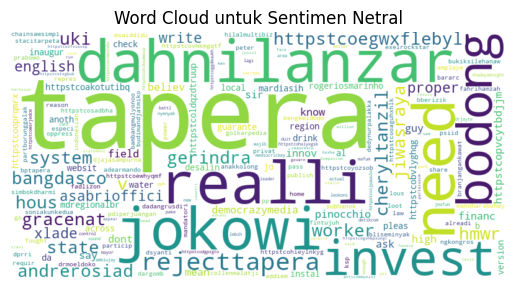

In [105]:
# Membuat WordCloud untuk sentimen netral
all_neutral_text = ' '.join(neutral_tweets)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(all_neutral_text)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Netral')

## 7. MODELLING

### 7.1 Memisahkan Data Training dan Testing

In [108]:
# memisahkan fitur dan label
x = data['tweet_clean']
y = data['sentiment_num']

# memisahkan data training dan testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### 7.2 Transformasi Data Teks ke Bentuk Vektor dengan TF-IDF

In [110]:
# menggunakan tfidfvectorizer
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

### 7.3 Algoritma Naive Bayes

In [112]:
# Inisiasi model Naive Bayes
nb = MultinomialNB()

# Melatih model
nb.fit(x_train_tfidf, y_train)

# Prediksi menggunakan model
y_pred_nb = nb.predict(x_test_tfidf)

# Evaluasi model Naive Bayes
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb, average='weighted')
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

print(f"Naive Bayes - Accuracy: {accuracy_nb}")
print(f"Naive Bayes - Precision: {precision_nb}")
print(f"Naive Bayes - Recall: {recall_nb}")
print(f"Naive Bayes - F1 Score: {f1_nb}")


Naive Bayes - Accuracy: 0.2727272727272727
Naive Bayes - Precision: 0.07438016528925619
Naive Bayes - Recall: 0.2727272727272727
Naive Bayes - F1 Score: 0.11688311688311687


### 7.4 Algoritma Suuport Vector Machine

In [113]:
# Inisiasi model SVM
svm = LinearSVC()

# Melatih model
svm.fit(x_train_tfidf, y_train)

# Prediksi menggunakan model
y_pred_svm = svm.predict(x_test_tfidf)

# Evaluasi model SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print(f"SVM - Accuracy: {accuracy_svm}")
print(f"SVM - Precision: {precision_svm}")
print(f"SVM - Recall: {recall_svm}")
print(f"SVM - F1 Score: {f1_svm}")


SVM - Accuracy: 0.45454545454545453
SVM - Precision: 0.4805194805194805
SVM - Recall: 0.45454545454545453
SVM - F1 Score: 0.40606060606060607


### 7.5 Hasil Evaluasi

In [114]:
# menyimpan hasil evaluasi dalam sebuah dictionary
evaluation_results = {
    'Model': ['Naive Bayes', 'SVM'],
    'Accuracy': [accuracy_nb, accuracy_svm],
    'Precision': [precision_nb, precision_svm],
    'Recall': [recall_nb, recall_svm],
    'F1 Score': [f1_nb, f1_svm]
}

# mengubah dictionary menjadi DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

# menampilkan hasil evaluasi
print(evaluation_df)


         Model  Accuracy  Precision    Recall  F1 Score
0  Naive Bayes  0.272727   0.074380  0.272727  0.116883
1          SVM  0.454545   0.480519  0.454545  0.406061


### 7.6 Visualisasi Hasil Evaluasi

<Figure size 1000x600 with 0 Axes>

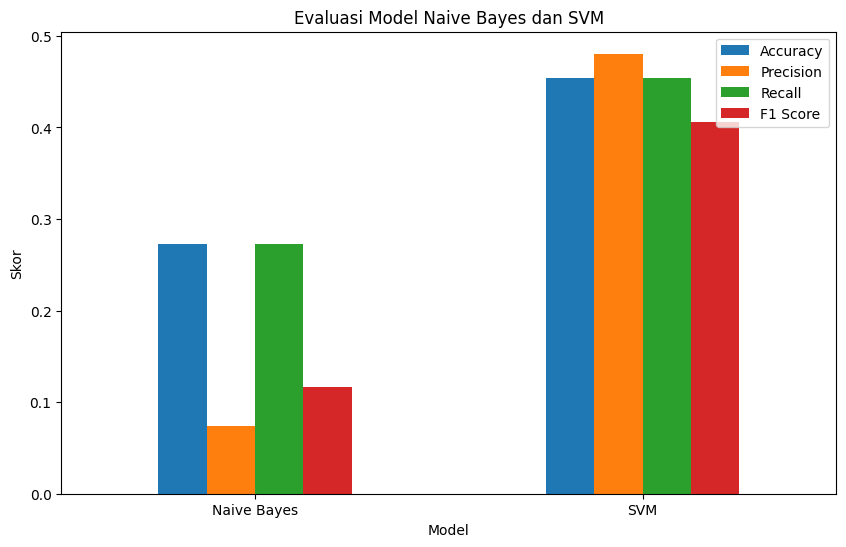

In [115]:
# plotting hasil evaluasi
plt.figure(figsize=(10, 6))
evaluation_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Evaluasi Model Naive Bayes dan SVM')
plt.xlabel('Model')
plt.ylabel('Skor')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()


### 7.7 Membandingkan Berbagai Ukuran Set Pengujian

In [116]:
test_sizes = [0.4, 0.3, 0.2, 0.1]
results = []

for test_size in test_sizes:
    # Memisahkan data training dan testing
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
    
    # Transformasi Data Teks ke Bentuk Vektor dengan TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
    x_test_tfidf = tfidf_vectorizer.transform(x_test)
    
    ### 7.3 Algoritma Naive Bayes
    # Inisiasi model Naive Bayes
    nb = MultinomialNB()

    # Melatih model
    nb.fit(x_train_tfidf, y_train)

    # Prediksi menggunakan model
    y_pred_nb = nb.predict(x_test_tfidf)

    # Evaluasi model Naive Bayes
    accuracy_nb = accuracy_score(y_test, y_pred_nb)
    precision_nb = precision_score(y_test, y_pred_nb, average='weighted')
    recall_nb = recall_score(y_test, y_pred_nb, average='weighted')
    f1_nb = f1_score(y_test, y_pred_nb, average='weighted')
    
    ### 7.4 Algoritma Support Vector Machine (SVM)
    # Inisiasi model SVM
    svm = LinearSVC()

    # Melatih model
    svm.fit(x_train_tfidf, y_train)

    # Prediksi menggunakan model
    y_pred_svm = svm.predict(x_test_tfidf)

    # Evaluasi model SVM
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
    recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
    f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
    
    # Menyimpan hasil evaluasi dalam sebuah dictionary
    result_nb = {
        'Model': 'Naive Bayes',
        'Test Size': test_size,
        'Accuracy': accuracy_nb,
        'Precision': precision_nb,
        'Recall': recall_nb,
        'F1 Score': f1_nb
    }
    
    result_svm = {
        'Model': 'SVM',
        'Test Size': test_size,
        'Accuracy': accuracy_svm,
        'Precision': precision_svm,
        'Recall': recall_svm,
        'F1 Score': f1_svm
    }
    
    results.append(result_nb)
    results.append(result_svm)


### 7.8 Hasil Evaluasi Set Pengujian

In [117]:
# mengubah hasil evaluasi menjadi DataFrame
evaluation_df = pd.DataFrame(results)

# menampilkan hasil evaluasi
print(evaluation_df)


         Model  Test Size  Accuracy  Precision    Recall  F1 Score
0  Naive Bayes        0.4  0.380952   0.145125  0.380952  0.210181
1          SVM        0.4  0.428571   0.420635  0.428571  0.360750
2  Naive Bayes        0.3  0.375000   0.140625  0.375000  0.204545
3          SVM        0.3  0.437500   0.462121  0.437500  0.395588
4  Naive Bayes        0.2  0.272727   0.074380  0.272727  0.116883
5          SVM        0.2  0.454545   0.480519  0.454545  0.406061
6  Naive Bayes        0.1  0.166667   0.033333  0.166667  0.055556
7          SVM        0.1  0.666667   0.458333  0.666667  0.539683


### 7.9 Visualisasi Hasil Evaluasi  Set Pengujian

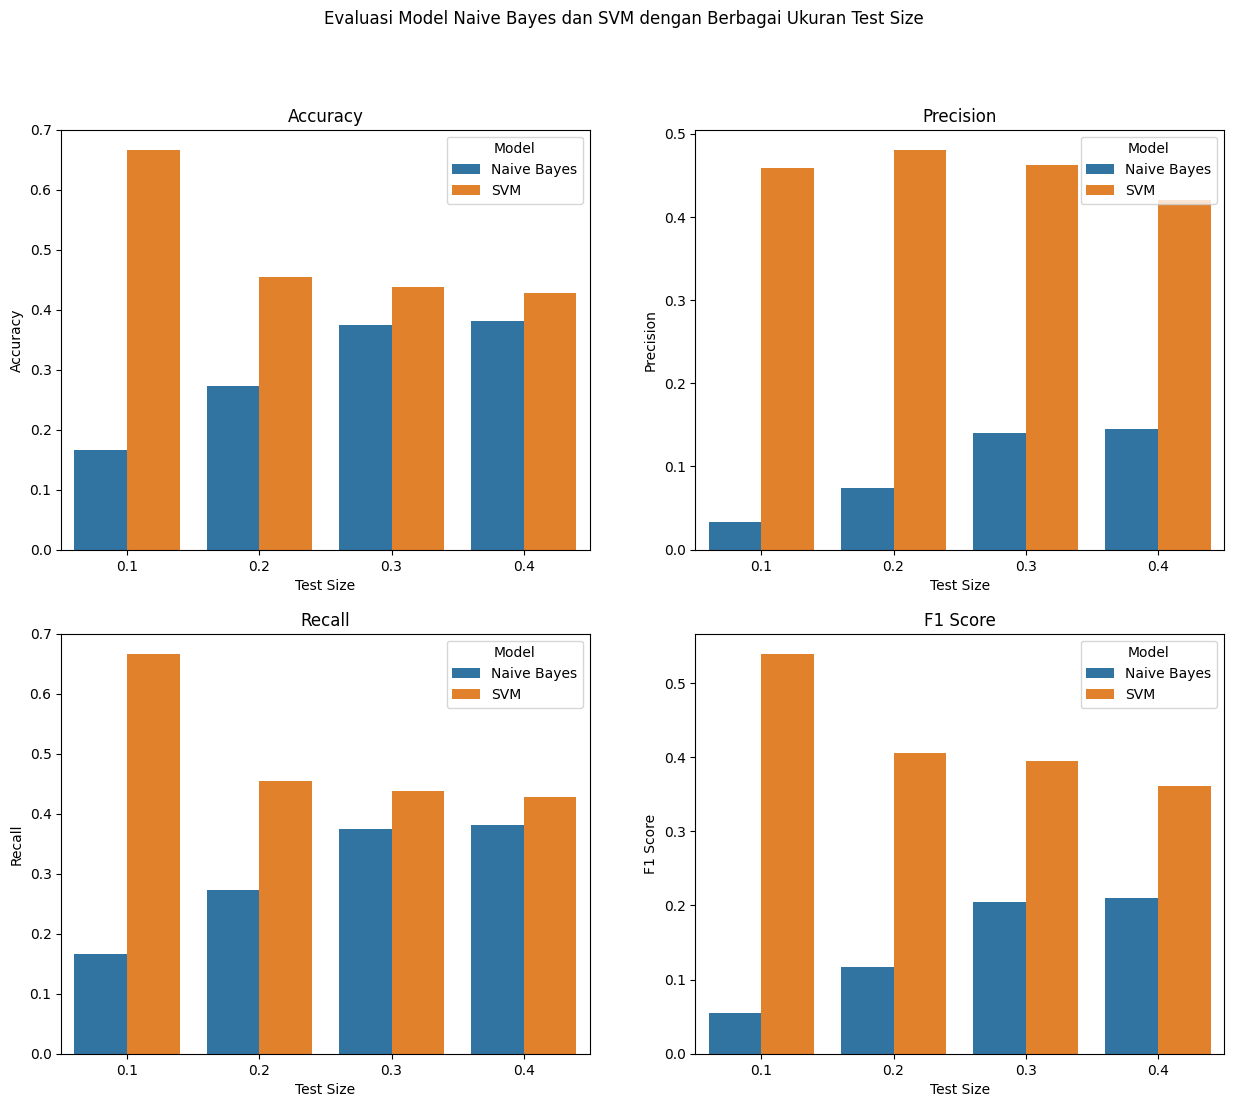

In [118]:
# plotting hasil evaluasi
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Evaluasi Model Naive Bayes dan SVM dengan Berbagai Ukuran Test Size')

sns.barplot(ax=axes[0, 0], data=evaluation_df, x='Test Size', y='Accuracy', hue='Model')
axes[0, 0].set_title('Accuracy')

sns.barplot(ax=axes[0, 1], data=evaluation_df, x='Test Size', y='Precision', hue='Model')
axes[0, 1].set_title('Precision')

sns.barplot(ax=axes[1, 0], data=evaluation_df, x='Test Size', y='Recall', hue='Model')
axes[1, 0].set_title('Recall')

sns.barplot(ax=axes[1, 1], data=evaluation_df, x='Test Size', y='F1 Score', hue='Model')
axes[1, 1].set_title('F1 Score')

plt.show()
